# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
# !pip install spacy

In [2]:
# !pip install nltk

In [3]:
# Подключение библиотек

import warnings
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas()

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, roc_curve 

# Настройки
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# Константы и др.

STATE = 123 # значение для параметра random_state

In [7]:
# Функция для очистки текста от посторонних символов,
# приведения к нижнему регистру

def clear_text(text):
    text = text.lower()
    text_clean = re.sub(r'[^a-zA-Z]', ' ', text).split()
    return ' '.join(text_clean)

In [8]:
# Функция для лемматизации текста

def lemmatize(text):
    words = nlp(text)
    return ' '.join([token.lemma_ for token in words])

In [10]:
# Функция для подбора наилучших гиперпараметров модели 
# Обучает модель на обучающем наборе данных, возвращает лучшие: модель, параметры и метрику качества (RMSE)

def best_model_params(model, params, features_train, target_train):
    
    gs_model = GridSearchCV(model, param_grid=params, scoring='f1', 
                            verbose=3, cv=5, n_jobs=-1)
    gs_model.fit(features_train, target_train)
    
    best_model = gs_model.best_estimator_
    best_params = gs_model.best_params_
    best_score = gs_model.best_score_
    
    return best_model, best_params, best_score

## Загрузка и подготовка данных

In [11]:
# Загрузка данных

try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [12]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [13]:
# Общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [14]:
# Удаляем неинформативный столбец 'Unnamed: 0' (дублирует индексы и/или не несёт информации для моделей обучения)

df.drop(columns='Unnamed: 0', inplace=True)

In [15]:
# Размер датасета

df.shape

(159292, 2)

In [16]:
# Проверка наличия явных дубликатов

df.duplicated().sum()

0

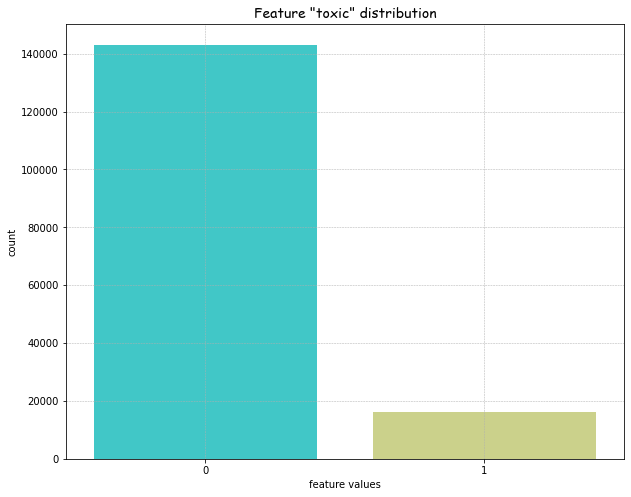

In [17]:
# Столбчатая диаграмма для целевого признака

plt.figure(figsize=(10, 8))

sns.countplot(data=df, x='toxic', palette='rainbow')

plt.grid(linewidth = 0.5, linestyle = '--')
plt.xlabel('feature values')
plt.title('Feature "{}" distribution'.format('toxic'), 
          fontdict={'fontsize': 14, 'fontfamily': 'cursive'})

plt.show()

In [18]:
# Смотрим на соотношение между значениями ц.п.

df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [19]:
df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]

8.841344371679229

Перед обучением подготовим данные, а именно, очистим их с помощью регулярных выражений и применим лемматизацию:

In [20]:
# Очистка текста

df['text'] = df['text'].apply(clear_text)

In [21]:
# Лемматизация

df['text'] = df['text'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [22]:
df['text'].head(10)

0    explanation why the edit make under my usernam...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
5    congratulation from I as well use the tool wel...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense be offensive to you...
9    alignment on this subject and which be contrar...
Name: text, dtype: object

#### Вывод:

Количество строк и столбцов таблицы: 159292 и 2 (один столбец удалён), соответственно. В данных нет пропусков. Явных дубликатов не обнаружено. Для целевого признака наблюдается дисбаланс классов, приблизительно 1 к 8.84 (в сторону класса "0"). Данные очищены и лемматизированы.

## Обучение

In [23]:
# Сохраним признаки и целевой признак (далее ц.п.) в отдельных переменных
# Введём обозначения: X - признаки, y - ц.п. (по аналогии с обозначениями выборок)

X = df.drop(columns='toxic') # извлекаем признаки

y = df['toxic'] # извлекаем целевой признак

Разобьём наши данные на тренировочную и тестовую выборки:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=STATE, stratify=y)

In [25]:
# Проверка

display(X_train.shape, X_test.shape)
display(y_train.shape, y_test.shape)

(143362, 1)

(15930, 1)

(143362,)

(15930,)

In [26]:
# Загружаем список стоп-слов

stop_w = list(stopwords.words('english'))

In [27]:
vectorizer = TfidfVectorizer(stop_words=stop_w)

In [28]:
X_train_new = vectorizer.fit_transform(X_train['text'])

In [29]:
display(X_train_new.shape)

(143362, 142343)

In [30]:
X_test_new = vectorizer.transform(X_test['text'])

In [31]:
display(X_test_new.shape)

(15930, 142343)

#### Логистическая регрессия 

In [32]:
lr_model = LogisticRegression(random_state=STATE)
lr_params = {'class_weight': ['balanced', None], 'C': np.arange(5, 16, 2)}

In [33]:
%%time

lr, lr_best_params, lr_score = best_model_params(lr_model, lr_params, X_train_new, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 7.33 s
Wall time: 3min 41s


In [34]:
print('Параметры "лучшей" модели ', lr_best_params)
print('Значение метрики качества: ', round(lr_score, 2))

Параметры "лучшей" модели  {'C': 15, 'class_weight': None}
Значение метрики качества:  0.77


#### SGD

In [35]:
sgd_model = SGDClassifier(random_state=STATE, shuffle=True)
sgd_params = {'class_weight': ['balanced', None], 'max_iter': np.arange(100, 301, 50), 
              'loss': ['log','hinge'], 'learning_rate': ['optimal', 'adaptive'], 
              'penalty': ['l1', 'l2']}

In [36]:
%%time

sgd, sgd_best_params, sgd_score = best_model_params(sgd_model, sgd_params, X_train_new, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
CPU times: total: 9.25 s
Wall time: 1min 50s


In [37]:
print('Параметры "лучшей" модели ', sgd_best_params)
print('Значение метрики качества: ', round(sgd_score, 2))

Параметры "лучшей" модели  {'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2'}
Значение метрики качества:  0.74


#### Дерево решений

In [38]:
dtc_model = DecisionTreeClassifier(random_state=STATE)
dtc_params = {'class_weight': ['balanced', None], 'max_depth': np.arange(10, 21, 2),}

In [39]:
%%time

dtc, dtc_best_params, dtc_score = best_model_params(dtc_model, dtc_params, X_train_new, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 19.8 s
Wall time: 12min 53s


In [40]:
print('Параметры "лучшей" модели ', dtc_best_params)
print('Значение метрики качества: ', round(dtc_score, 2))

Параметры "лучшей" модели  {'class_weight': None, 'max_depth': 20}
Значение метрики качества:  0.66


В качестве "лучшей" модели, с учётом наибольшего значения метрики, полученного на тренировочных данных, выбираем модель LogisticRegression, получим предсказания и значение метрики на тестовых данных:

In [41]:
target_pred = lr.predict(X_test_new)
f1_score(y_test, target_pred)

0.7860998650472335

Цель достигнута, на тестовых данных значение метрики качества `F1` составляет `0.76`, что больше установленного порога.

Посмотрим насколько хорошо модель определяет долю токсичных комментариев, используем метрику Recall (полнота):

In [42]:
# Значение recall достаточно близко к 1 (приблизительно 84% комментариев модель определяет верно)

print('Recall score {}'.format(recall_score(y_test, target_pred).round(3)))

Recall score 0.72


In [43]:
# Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем метрику AUC-ROC

probabilities_one_test = lr.predict_proba(X_test_new)[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)

print('AUC_ROC: {}'.format(auc_roc.round(3))) # метрика случайной модели 0.5

AUC_ROC: 0.97


In [44]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

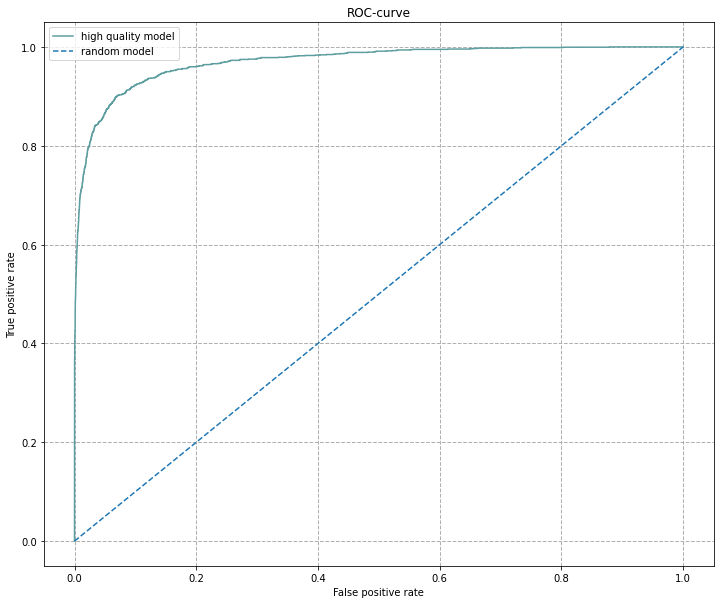

In [45]:
# Строим ROC-кривую 

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(12)  
fig.set_figheight(10)

ax.plot(fpr, tpr, color='cadetblue', label='high quality model')
ax.plot([0, 1], [0, 1], linestyle='--', label='random model')

ax.legend()
ax.grid(linewidth=1,   
        linestyle='--')

# добавляем название графика
ax.set(title='ROC-curve')

# добавляем подписи к осям:
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

plt.show() # чем график выше, тем лучше качество модели

## Выводы

На этапе предобработки подготовлены данные: удалены посторонние символы, проведены токенизация и лемматизация текстовых данных. Подготовлены векторы признаков с использованием TF-IDF и стоп-слов. На тренировочных данных обучены модели: логистическая регрессия, логистическая регрессия со стохастическим градиентным спускоми и дерево решений. Наилучшее значение метрики качества `F1` получено для модели логистической регрессии. Использование метода SGD ведёт к незначительному снижению качества, но даёт большую скорость при обучении модели. "Деревянная" модель оказалась худшей по обоим параметрам (качество и скорость обучения). Лучшая модель протестирована, требуемый порог качества достигнут.